In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import tqdm
import json
import torch
import warnings
import numpy as np
import torch.nn as nn
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt
from chnet.torchsummary import summary
from torchvision import transforms, utils
from toolz.curried import pipe, curry, compose
from torch.utils.data import Dataset, DataLoader

In [3]:
import utilities as utils
import chnet.cahn_hill as ch
import chnet.ch_tools as tools

In [4]:
from chnet.unet import UNet
from chnet.ch_net import CHnet
from chnet.ch_loader import CahnHillDataset

In [5]:
warnings.filterwarnings('ignore')

In [6]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
@curry
def return_slice(x_data, cutoff):
    if cutoff is not None:
        return pipe(x_data,
                    lambda x_data: np.asarray(x_data.shape).astype(int) // 2,
                    lambda new_shape: [slice(new_shape[idim]-cutoff,
                                             new_shape[idim]+cutoff+1)
                                       for idim in range(x_data.ndim)],
                    lambda slices: x_data[slices])
    else:
        return x_data
    
cropper = return_slice(cutoff=5)

In [7]:
def init_unif(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    return np.random.uniform(-0.95, 0.95, size=(nsamples, dim_x, dim_y))


def init_norm(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.1, 0.1, size=nsamples)
    np.random.seed(seed)
    scales  = np.random.uniform(0.1, 0.5, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.95, 0.95, out=x_data)
    
    return x_data

## Loss Functions

In [8]:
@curry
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    return ((y1 - y2) ** 2).sum() / y1.data.nelement() * scale

@curry
def rmse_loss(y1, y2, scale=1.):
    """standard RMSE definition"""
    return ((((y1 - y2) ** 2).sum() / y1.data.nelement()).sqrt()) * scale


def mse_loss_npy(y1, y2):
    """standard MSE definition"""
    return np.sum(((y1 - y2) ** 2)) / y1.size

## Transformers

In [9]:
@curry
def add_neighbors(x):
    dimx = x.shape[0]
    y = np.pad(x, pad_width=[[2,2],[2,2]], mode="wrap")
    out = [x[None]]
    for ix in [0, 1, 2, 3, 4]:
        for iy in [0, 1, 2, 3, 4]:
            out.append((y[ix:ix+dimx, iy:iy+dimx] * x)[None])
    return np.concatenate(out, axis=0)

## Data Generators

In [10]:
@curry
def data_generator(nsamples=16, 
                   dim_x=64, 
                   init_steps=100, 
                   delta_sim_steps = 500,
                   dx = 0.25, 
                   dt = 0.01,
                   gamma=1.0, 
                   seed = None,
                   device = torch.device("cuda:0")):
    
    init_data1 = init_unif(nsamples//2, dim_x, dim_x, seed=seed)
    init_data2 = init_norm(nsamples//2, dim_x, dim_x, seed=seed)
    init_data = np.concatenate([init_data1, init_data2], axis=0)
    
    x_data = ch.ch_run_torch(init_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps, device=device)
    y_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps+delta_sim_steps, device=device)
    return x_data, y_data

# Set Device

In [11]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda")

## Data Generation

In [12]:
x_data, y_data = data_generator(nsamples=16, dim_x=64, 
                                init_steps=10, 
                                delta_sim_steps = 50,
                                dx = 0.25, 
                                dt = 0.01,
                                gamma=1.0, 
                                seed = None,
                                device = device)

# CNN Model

In [13]:
# model = torch.hub.load('pytorch/vision:v0.5.0', 'fcn_resnet101', pretrained=False)
# summary(model, input_size=(1, 64, 64))

# # model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', 
# #                        in_channels=1, 
# #                        out_channels=1, 
# #                        init_features=32, 
# #                        pretrained=False).double().to(device)

In [13]:
transformer_x = lambda x: x[None]
transformer_y = lambda x: x[None]

dataset = CahnHillDataset(x_data, y_data, transform_x=transformer_x, transform_y=transformer_y)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)

print(x.shape, y.shape)

torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])


In [14]:
from chnet.fcn import FCN

In [32]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(32, 16, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [21]:
# from chnet.unet import UNet
# from chnet.vae import VAE
# model = VAE(in_channels=1, out_channels=1).double().to(device)

In [33]:
model = autoencoder().double().to(device)
summary(model, dtypes=[torch.double], input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 22, 22]             320
              ReLU-2           [-1, 32, 22, 22]               0
         MaxPool2d-3           [-1, 32, 11, 11]               0
            Conv2d-4             [-1, 16, 6, 6]           4,624
              ReLU-5             [-1, 16, 6, 6]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
   ConvTranspose2d-7           [-1, 32, 11, 11]           4,640
              ReLU-8           [-1, 32, 11, 11]               0
   ConvTranspose2d-9           [-1, 32, 33, 33]          25,632
             ReLU-10           [-1, 32, 33, 33]               0
  ConvTranspose2d-11            [-1, 1, 64, 64]             129
             Tanh-12            [-1, 1, 64, 64]               0
      autoencoder-13            [-1, 1, 64, 64]               0
Total params: 35,345
Trainable params: 

(tensor(35345), tensor(35345))

In [34]:
# model = VAE(in_channels=1, out_channels=1).double().to(device)
model = autoencoder().double().to(device)
item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)
y_pred = model(x)

assert y.shape == y_pred.shape
print(mse_loss(y, y_pred).data)

tensor(0.0580, device='cuda:0', dtype=torch.float64)


# Model Training

### Training and Validation data generation

In [39]:
## Process Parameters
dim_x=64
init_steps=10
delta_sim_steps = 2000
dx = 0.25 
dt = 0.01
gamma=1.0

seed_trn = 110364
seed_val = 986423
seed_prd = 284296

n_samples_trn = 1024*10
n_samples_val = 128
n_samples_prd = 32

init_features=64

In [40]:
args = {}
args["dim_x"] = dim_x
args["init_steps"] = init_steps
args["delta_sim_steps"] = delta_sim_steps
args["dx"] = dx
args["dt"] = dt
args["gamma"] = gamma
args["seed_trn"] = seed_trn
args["seed_val"] = seed_val
args["seed_val"] = seed_prd

args["n_samples_trn"] = n_samples_trn
args["n_samples_val"] = n_samples_val
args["n_samples_prd"] = n_samples_prd

args["init_features"] = init_features

In [41]:
%%time
x_trn, y_trn = data_generator(nsamples=n_samples_trn, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_trn,
                                device = device)



x_val, y_val = data_generator(nsamples=n_samples_val, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_val,
                                device = device)

x_prd, y_prd = data_generator(nsamples=n_samples_prd, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_prd,
                                device = device)

CPU times: user 20.9 s, sys: 17.9 s, total: 38.8 s
Wall time: 37.2 s


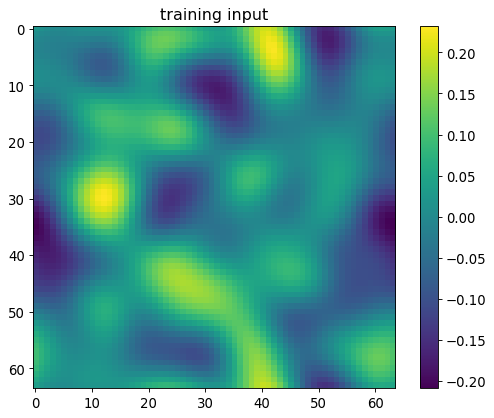

In [42]:
draw_im(x_trn[0], "training input")

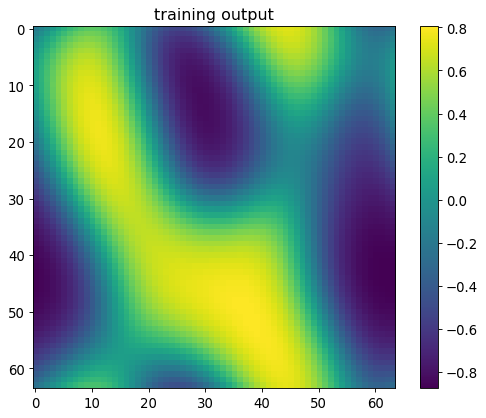

In [43]:
draw_im(y_trn[0], "training output")

In [44]:
transformer_x = lambda x: x[None]
transformer_y = lambda x: x[None]

trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=transformer_x, transform_y=transformer_y)
val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
prd_dataset = CahnHillDataset(x_prd, y_prd, transform_x=transformer_x, transform_y=transformer_y)

batch_size = 32

trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
prd_loader = DataLoader(prd_dataset, batch_size=8, shuffle=True, num_workers=1)


total_step = len(trn_loader)
print("No. of training steps: %d" % total_step)
total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)
total_val_step = len(prd_loader)
print("No. of prediction steps: %d" % total_val_step)

No. of training steps: 320
No. of validation steps: 4
No. of prediction steps: 4


In [46]:
dt_string = datetime.now().strftime("%d-%m-%Y-%H-%M")

In [47]:
run_id = dt_string + "_run_" + "autoencoder"
print(run_id)

folder = "out/unet/ch_unet_id_{}/".format(run_id)
print(folder)

if not os.path.exists(folder):
    os.makedirs(folder)
    
with open(folder+'params.json', 'w') as fp:
    json.dump(args, fp)
    
tag = folder+"unet_"
print(tag)

12-04-2020-15-07_run_autoencoder
out/unet/ch_unet_id_12-04-2020-15-07_run_autoencoder/
out/unet/ch_unet_id_12-04-2020-15-07_run_autoencoder/unet_


In [49]:
from chnet.vae import VAE
# model = VAE(in_channels=1, out_channels=1).double().to(device)
model = autoencoder().double().to(device)

In [51]:
num_epochs = 10
criterion = mse_loss(scale=10000)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
trn_losses = []
val_losses = []

In [52]:
# Loss and optimizer
for epoch in range(num_epochs):    
    torch.save(model.state_dict(), tag+"epoch_{}.pt".format(epoch))              
    for i, item_trn in enumerate(tqdm.tqdm_notebook(trn_loader)):
        
        
        model.train()
        
        x = item_trn['x'].to(device)
        y_tru = item_trn['y'].to(device)

        # Forward pass
        y_prd = model(x)[0]
        loss = criterion(y_tru, y_prd)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trn_losses.append(np.sqrt(loss.item()))
        
        if (i) % 256 == 0:
            for item_val in val_loader:
                model.eval()
                x1 = item_trn['x'].to(device)
                y1 = item_trn['y'].to(device)
                # Forward pass
                y2 = model(x1)[0]
                val_losses.append(np.sqrt(criterion(y2, y1).item()))
                    
            print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}, Validation Loss: {:.11f}'.format(epoch+1, 
                                                                                                          num_epochs, 
                                                                                                          i+1, 
                                                                                                          total_step, 
                                                                                                          np.mean(trn_losses[-16:]), 
                                                                                                          np.mean(val_losses[-total_val_step:])))
            
# torch.save(model.state_dict(), tag+"epoch_{}.pt".format(num_epochs)) 

Epoch [1/10], Step [1/320], Training Loss: 51.04852096205, Validation Loss: 288.76295298282
Epoch [1/10], Step [257/320], Training Loss: 49.98617544768, Validation Loss: 279.38750386792



Epoch [2/10], Step [1/320], Training Loss: 50.27242018462, Validation Loss: 285.67292077432
Epoch [2/10], Step [257/320], Training Loss: 49.00697294167, Validation Loss: 272.75538917211



Epoch [3/10], Step [1/320], Training Loss: 49.07423767415, Validation Loss: 266.77733666648
Epoch [3/10], Step [257/320], Training Loss: 48.81123869423, Validation Loss: 272.31200516528



Epoch [4/10], Step [1/320], Training Loss: 48.35257881081, Validation Loss: 284.94414179934
Epoch [4/10], Step [257/320], Training Loss: 47.90417439448, Validation Loss: 276.03673301879



Epoch [5/10], Step [1/320], Training Loss: 48.21855954845, Validation Loss: 272.45479447212
Epoch [5/10], Step [257/320], Training Loss: 48.26364288081, Validation Loss: 282.48938883884



Epoch [6/10], Step [1/320], Training Loss: 48.48008691754, Validation Loss: 282.37048536501
Epoch [6/10], Step [257/320], Training Loss: 48.51471686335, Validation Loss: 269.05931739803



Epoch [7/10], Step [1/320], Training Loss: 47.64553488266, Validation Loss: 281.81448707657
Epoch [7/10], Step [257/320], Training Loss: 48.20332709652, Validation Loss: 274.71502909635



Epoch [8/10], Step [1/320], Training Loss: 48.30513553098, Validation Loss: 270.49120152634
Epoch [8/10], Step [257/320], Training Loss: 48.15433756858, Validation Loss: 269.82976224477



Epoch [9/10], Step [1/320], Training Loss: 47.88914562468, Validation Loss: 273.65828955219
Epoch [9/10], Step [257/320], Training Loss: 48.03749808239, Validation Loss: 261.34075789078



Epoch [10/10], Step [1/320], Training Loss: 48.03058861161, Validation Loss: 268.34854587795
Epoch [10/10], Step [257/320], Training Loss: 48.34852450499, Validation Loss: 269.81301937360



In [10]:
plt.plot(trn_losses)
plt.plot(val_losses)
plt.title("training losses")
plt.xlabel("training steps")
plt.ylabel("mean squared error")
plt.legend(["trn", "val"])
plt.show()

NameError: name 'trn_losses' is not defined

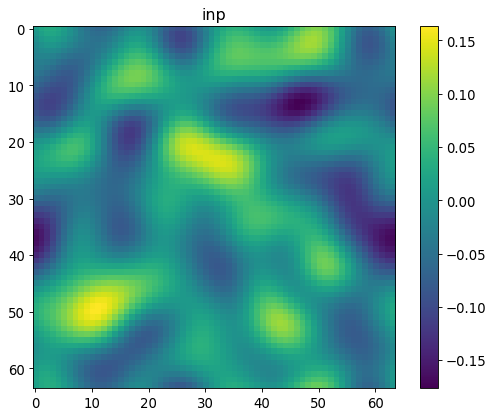

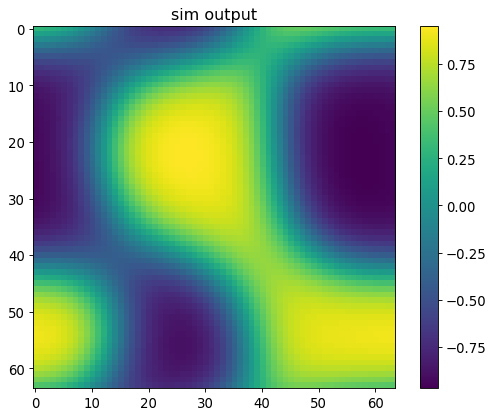

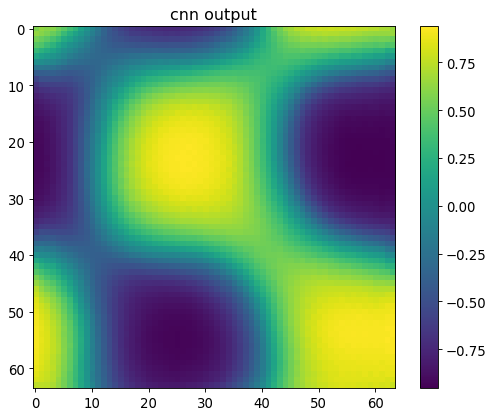

In [72]:
ix = 12

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(y1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

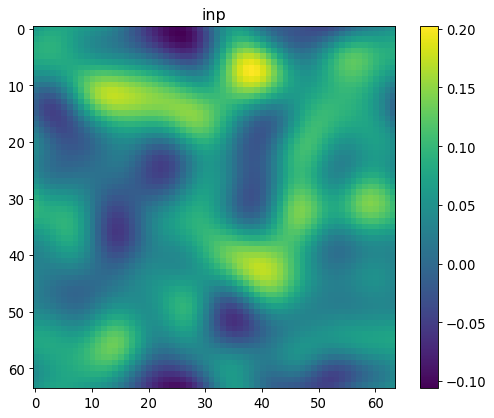

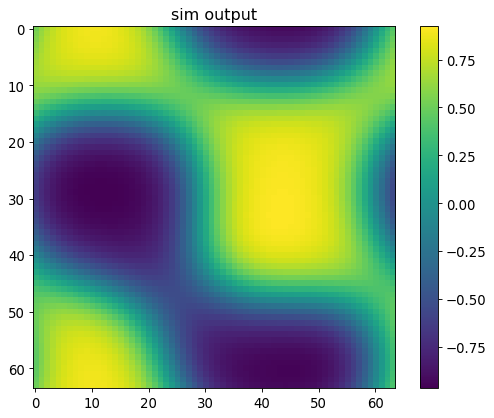

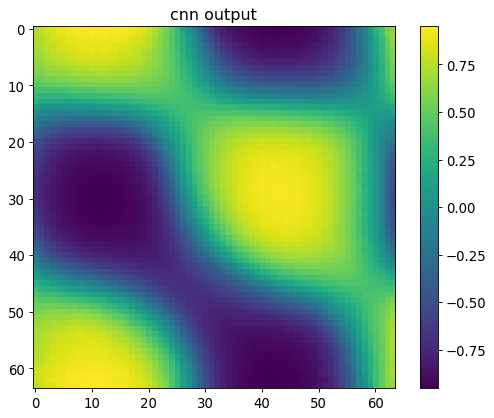

In [74]:
ix = 30

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(y1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")